In [1]:
import os
from os.path import join
import json
from copy import deepcopy

import spacy
nlp_spacy = spacy.load("en_core_web_trf")
import nltk
# import textpipeliner
# from textpipeliner import PipelineEngine, Context
# from textpipeliner.pipes import *
from subject_verb_object_extract_test import findSVOs, nlp

# import responsibly
# from responsibly.we import weat
# from gensim import downloader
# from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, get_single_color_func

/home/gohar/miniconda3/envs/privacy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Captions

In [2]:
cap_dir = "/home/gohar/Privacy/CLIP_prefix_caption/results"

cap_dict = {}
for file in os.listdir(cap_dir):
    # print(file)
    with open(join(cap_dir, file)) as json_file:
        caps = json.load(json_file)
        caps = list(caps.values())
        
    attribute = file.split("_")[1]
    mod = file.split("_")[2]
    dataset = file.split("_")[-1].split(".")[0]
    if dataset != "conceptual-captions":
        continue
    print(attribute, dataset, mod)
    
    if attribute not in cap_dict.keys():
        cap_dict[attribute] = {}
    
    if dataset not in cap_dict[attribute]:
        cap_dict[attribute][dataset] = {}
    
    cap_dict[attribute][dataset][mod] = caps

dark conceptual-captions mod
dark conceptual-captions orig


## Extracting Subjects / Verbs

### SVO package

In [16]:
if os.path.exists("/home/gohar/Privacy/CLIP_prefix_caption/results/val2014_dark_conceptual-captions_svos.json"):
    with open("/home/gohar/Privacy/CLIP_prefix_caption/results/val2014_dark_conceptual-captions_svos.json") as json_file:
        svo_dict2 = json.load(json_file)

In [10]:
# svo_dict1 = deepcopy(cap_dict)
svo_dict2 = deepcopy(cap_dict)

for attribute in cap_dict.keys():
    for dataset in cap_dict[attribute].keys():
        for mod in cap_dict[attribute][dataset].keys():
            caps = cap_dict[attribute][dataset][mod]

            # tokens = nlp(" ".join(caps))
            # svos = findSVOs(tokens)
            # svo_dict1[attribute][dataset][mod] = svos
            
            svos2 = []
            for cap in caps:
                tokens2 = nlp(cap)
                svo2 = findSVOs(tokens2)
                svos2.append(svo2)
            svo_dict2[attribute][dataset][mod] = svos2

with open("/home/gohar/Privacy/CLIP_prefix_caption/results/val2014_dark_conceptual-captions_svos.json", "w") as outfile:
    json.dump(svo_dict2, outfile)


### Spacy

In [12]:
attribute = "dark"
dataset = "conceptual-captions"

verb_dict = deepcopy(cap_dict)
for i, mod in enumerate(cap_dict[attribute][dataset].keys()):
    caps = cap_dict[attribute][dataset][mod]

    verbs = []
    for cap in caps:
        doc_cap = nlp_spacy(cap)
        for token in doc_cap:
            if token.pos_ == "VERB": verbs.append(token.lemma_)
    
    verb_dict[attribute][dataset][mod] = verbs

In [13]:
with open(f"/home/gohar/Privacy/CLIP_prefix_caption/results/val2014_{attribute}_{dataset}_verbs.json", "w") as outfile:
    json.dump(verb_dict, outfile)

In [20]:
attribute = "dark"
dataset = "conceptual-captions"

subject_dict = deepcopy(svo_dict2)
for i, mod in enumerate(svo_dict2[attribute][dataset].keys()):
    svos = svo_dict2[attribute][dataset][mod]
    subjects = [svo[0][0] for svo in svos if len(svo) != 0]
    subjects = " ".join(subjects).split(" ")

    common_subj_list = ["person", "man", "woman", "boy", "girl", "people",
                        "group", "in", "shirt", "black", "left", "photo",
                        "layer", "ice", "the", "area",
                        "I", "a", "i", "this", "of", "my", "what", "4k",
                        "t", "-", ",", ".", "on", "his"]
    subjects = [subject for subject in subjects if subject not in common_subj_list]
    subject_dict[attribute][dataset][mod] = subjects
    # print(subjects)
    # break

In [21]:
with open(f"/home/gohar/Privacy/CLIP_prefix_caption/results/val2014_{attribute}_{dataset}_subjects.json", "w") as outfile:
    json.dump(subject_dict, outfile)

## Other Analysis

In [60]:

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

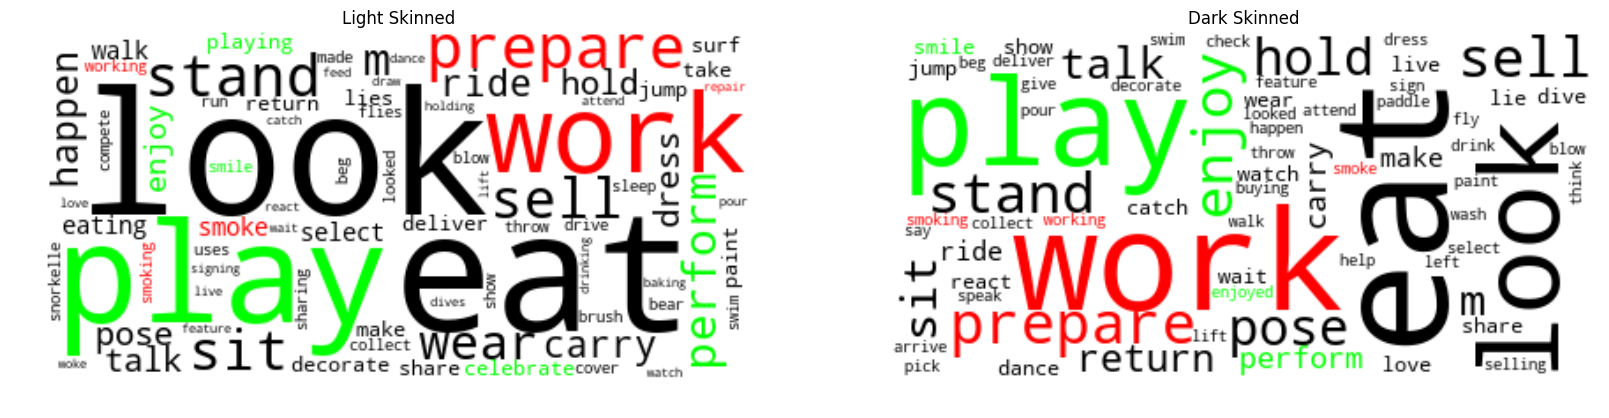

In [65]:
fig, axs = plt.subplots(1,2, figsize = (20,20))
color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': ['play', 'plays', 'played', 'playing',
                 'perform', 'performs', 'perform', 'performing', 
                 'smile', 'smiles', 'smiled', 'smiling', 
                 "enjoy", "enjoyed", "enjoying", "enjoys",
                 "celebrate", "celebrates", 'celebrated', 'celebrating'],
    # will be colored with a red single color function
    'red': ['work','works', 'worked', 'working', 
                'smoke', 'smokes', 'smoking', 'smoked', 
                'repair', 'repairs', 'reparing', 'repaired',
                "prepare", 'prepares', 'preparing', 'prepared']
}
default_color = "black"

attribute = "dark"
dataset = "conceptual-captions"
for i, mod in enumerate(svo_dict2[attribute][dataset].keys()):
    svos = svo_dict2[attribute][dataset][mod]
    verbs = [svo[0][1] for svo in svos if len(svo) != 0]

    doc_spacy = nlp_spacy(" ".join(verbs))
    verbs_clean = [token.lemma_ for token in doc_spacy]
    # stemmer = nltk.stem.snowball.SnowballStemmer("english")
    # verbs_clean2 = [stemmer.stem(verb) for verb in verbs_clean]

    word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(" ".join(verbs_clean))

    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    word_cloud1.recolor(color_func=grouped_color_func)

    axs[i].imshow(word_cloud1, interpolation='bilinear')
    axs[i].set_title("Dark Skinned" if mod == "orig" else "Light Skinned")
    axs[i].axis("off") 

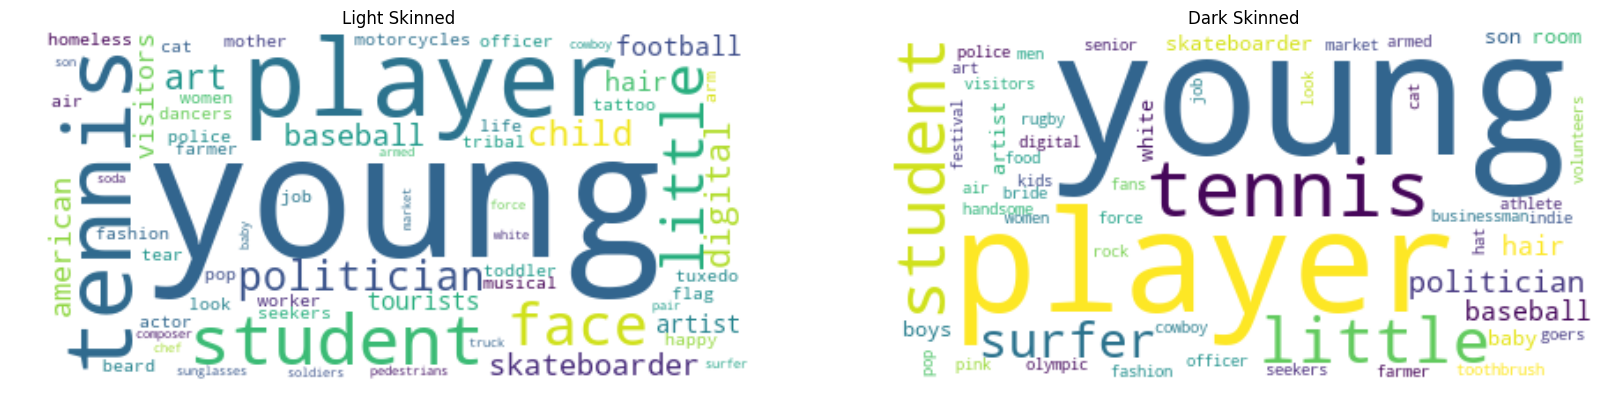

In [78]:
fig, axs = plt.subplots(1,2, figsize = (20,20))
color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': ['play', 'plays', 'played', 'playing',
                 'perform', 'performs', 'perform', 'performing', 
                 'smile', 'smiles', 'smiled', 'smiling', 
                 "enjoy", "enjoyed", "enjoying", "enjoys",
                 "celebrate", "celebrates", 'celebrated', 'celebrating'],
    # will be colored with a red single color function
    'red': ['work','works', 'worked', 'working', 
                'smoke', 'smokes', 'smoking', 'smoked', 
                'repair', 'repairs', 'reparing', 'repaired',
                "prepare", 'prepares', 'preparing', 'prepared']
}
default_color = "black"

attribute = "dark"
dataset = "conceptual-captions"
for i, mod in enumerate(svo_dict2[attribute][dataset].keys()):
    svos = svo_dict2[attribute][dataset][mod]
    subjects = [svo[0][0] for svo in svos if len(svo) != 0]
    subjects = " ".join(subjects).split(" ")
    # print(subjects)
    doc_spacy = nlp_spacy(" ".join(subjects))
    # verbs_clean = [token.lemma_ for token in doc_spacy]
    # stemmer = nltk.stem.snowball.SnowballStemmer("english")
    # verbs_clean2 = [stemmer.stem(verb) for verb in verbs_clean]

    common_subj_list = ["person", "man", "woman", "boy", "girl", "people",
                        "group", "in", "shirt", "black", "left", "photo",
                        "layer", "ice", "the", "area",
                        "I", "a", "i", "this", "of", "my", "what", "4k",
                        "t", "-", ",", ".", "on", "his"]
    subjects = [subject for subject in subjects if subject not in common_subj_list]
    # print(subjects)
    word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(" ".join(subjects))

    # grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    # word_cloud1.recolor(color_func=grouped_color_func)

    axs[i].imshow(word_cloud1, interpolation='bilinear')
    axs[i].set_title("Dark Skinned" if mod == "orig" else "Light Skinned")
    axs[i].axis("off") 
    # break

In [75]:
test_doc= nlp_spacy("young")

In [76]:

for token in test_doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

young young ADJ JJ ROOT


## text pipeliner

In [30]:
pipes_structure = [
    # SequencePipe([
        FindTokensPipe("VERB/nsubj/*"),
        # NamedEntityFilterPipe(),
        # NamedEntityExtractorPipe()
    # ]),
    FindTokensPipe("VERB")]

for attribute in cap_dict.keys():
    for dataset in cap_dict[attribute].keys():
        for mod in cap_dict[attribute][dataset].keys():
            caps = cap_dict[attribute][dataset][mod]
            print(caps[0])
            doc = nlp(caps[0])
            # doc = nlp(" ".join(caps))
            engine = PipelineEngine(pipes_structure, Context(doc))
            print(engine.process())
            print(caps[6])
            doc = nlp(caps[6])
            # doc = nlp(" ".join(caps))
            engine = PipelineEngine(pipes_structure, Context(doc))
            print(engine.process())
            break
        break

person enjoying a meal at a restaurant.
[([], [])]
a young girl looks at a black bear in a fence.
[([girl], [looks])]
